## Intelligent Agent Training in a Grid-Based Snake Game Environment using Q-Learning and SARSA Approach

In [ ]:
import pygame
import random
import numpy as np
import imageio
import matplotlib.pyplot as plt
from enum import Enum
from collections import deque
import os


pygame 2.6.1 (SDL 2.28.4, Python 3.11.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [ ]:
WIDTH, HEIGHT = 320, 240
BLOCK_SIZE = 20
WHITE = (255, 255, 255)
RED = (200, 0, 0)
BLUE1 = (0, 0, 255)
BLACK = (0, 0, 0)

In [ ]:
class Direction(Enum):
    RIGHT = 1
    LEFT = 2
    UP = 3
    DOWN = 4

In [ ]:
class Point:
    def __init__(self, x, y): self.x, self.y = x, y
    def __eq__(self, other): return self.x == other.x and self.y == other.y
    def __hash__(self): return hash((self.x, self.y))

In [ ]:
class SnakeGame:
    def __init__(self, record=False):
        pygame.init()
        self.display = pygame.Surface((WIDTH, HEIGHT))
        self.clock = pygame.time.Clock()
        self.frames = [] if record else None
        self.reset()

    def reset(self):
        self.direction = Direction.RIGHT
        x, y = WIDTH // 2, HEIGHT // 2
        self.head = Point(x, y)
        self.snake = [self.head,
                      Point(x - BLOCK_SIZE, y),
                      Point(x - 2 * BLOCK_SIZE, y)]
        self.score = 0
        self.food = None
        self.frame_iteration = 0
        self._place_food()

    def _place_food(self):
        while True:
            x = random.randint(0, (WIDTH - BLOCK_SIZE) // BLOCK_SIZE) * BLOCK_SIZE
            y = random.randint(0, (HEIGHT - BLOCK_SIZE) // BLOCK_SIZE) * BLOCK_SIZE
            self.food = Point(x, y)
            if self.food not in self.snake:
                break

    def play_step(self, action):
     self.frame_iteration += 1
     prev_distance = abs(self.head.x - self.food.x) + abs(self.head.y - self.food.y)

     self._move(action)
     self.snake.insert(0, self.head)

     reward = 0
     game_over = False

     if self.is_collision() or self.frame_iteration > 1000:
        reward = -10
        game_over = True
        return reward, game_over, self.score

     new_distance = abs(self.head.x - self.food.x) + abs(self.head.y - self.food.y)

     if self.head == self.food:
        self.score += 1
        reward = 10
        self._place_food()
     else:
        self.snake.pop()
        if new_distance < prev_distance:
            reward = 1
        else:
            reward = -1

     self._update_ui()
     return reward, game_over, self.score



    def is_collision(self, pt=None):
        pt = pt or self.head
        return (
            pt.x < 0 or pt.x >= WIDTH or
            pt.y < 0 or pt.y >= HEIGHT or
            pt in self.snake[1:]
        )

    def _update_ui(self):
        self.display.fill(BLACK)
        for pt in self.snake:
            pygame.draw.rect(self.display, BLUE1, pygame.Rect(pt.x, pt.y, BLOCK_SIZE, BLOCK_SIZE))
        pygame.draw.rect(self.display, RED, pygame.Rect(self.food.x, self.food.y, BLOCK_SIZE, BLOCK_SIZE))
        if self.frames is not None:
            arr = pygame.surfarray.array3d(self.display)
            self.frames.append(np.transpose(arr, (1, 0, 2)))

    def _move(self, action):
        clockwise = [Direction.RIGHT, Direction.DOWN, Direction.LEFT, Direction.UP]
        idx = clockwise.index(self.direction)

        if action == [1, 0, 0]:
            new_dir = clockwise[idx]
        elif action == [0, 1, 0]:
            new_dir = clockwise[(idx + 1) % 4]
        else:
            new_dir = clockwise[(idx - 1) % 4]

        self.direction = new_dir

        x, y = self.head.x, self.head.y
        if self.direction == Direction.RIGHT: x += BLOCK_SIZE
        elif self.direction == Direction.LEFT: x -= BLOCK_SIZE
        elif self.direction == Direction.DOWN: y += BLOCK_SIZE
        elif self.direction == Direction.UP: y -= BLOCK_SIZE
        self.head = Point(x, y)

In [ ]:
class QLearningAgent:
    def __init__(self):
        self.q_table = {}
        self.epsilon = 80
        self.gamma = 0.9
        self.lr = 0.1
        self.n_games = 0

    def get_state(self, game):
        head = game.snake[0]
        state = (
            game.is_collision(Point(head.x + BLOCK_SIZE, head.y)),
            game.is_collision(Point(head.x - BLOCK_SIZE, head.y)),
            game.is_collision(Point(head.x, head.y - BLOCK_SIZE)),
            game.is_collision(Point(head.x, head.y + BLOCK_SIZE)),
            game.food.x < head.x,
            game.food.x > head.x,
            game.food.y < head.y,
            game.food.y > head.y
        )
        return str(state)

    def get_action(self, state):
        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 2)
        else:
            qs = [
                self.q_table.get((state, (1, 0, 0)), 0),
                self.q_table.get((state, (0, 1, 0)), 0),
                self.q_table.get((state, (0, 0, 1)), 0)
            ]
            move = np.argmax(qs)
        return [int(i == move) for i in range(3)]

    def update_q(self, state, action, reward, next_state, done):
        old_q = self.q_table.get((state, tuple(action)), 0)
        future_q = max([self.q_table.get((next_state, tuple(a)), 0) for a in [[1, 0, 0], [0, 1, 0], [0, 0, 1]]])
        new_q = reward + self.gamma * future_q * (1 - int(done))
        self.q_table[(state, tuple(action))] = old_q + self.lr * (new_q - old_q)

In [ ]:
class SarsaAgent:
    def __init__(self):
        self.q_table = {}
        self.epsilon = 80
        self.gamma = 0.9
        self.lr = 0.1
        self.n_games = 0

    def get_state(self, game):
        head = game.snake[0]
        state = (
            game.is_collision(Point(head.x + BLOCK_SIZE, head.y)),
            game.is_collision(Point(head.x - BLOCK_SIZE, head.y)),
            game.is_collision(Point(head.x, head.y - BLOCK_SIZE)),
            game.is_collision(Point(head.x, head.y + BLOCK_SIZE)),
            game.food.x < head.x,
            game.food.x > head.x,
            game.food.y < head.y,
            game.food.y > head.y
        )
        return str(state)

    def get_action(self, state):
        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 2)
        else:
            qs = [
                self.q_table.get((state, (1, 0, 0)), 0),
                self.q_table.get((state, (0, 1, 0)), 0),
                self.q_table.get((state, (0, 0, 1)), 0)
            ]
            move = np.argmax(qs)
        return [int(i == move) for i in range(3)]

    def update_q(self, state, action, reward, next_state, next_action, done):
        old_q = self.q_table.get((state, tuple(action)), 0)
        future_q = self.q_table.get((next_state, tuple(next_action)), 0)
        new_q = reward + self.gamma * future_q * (1 - int(done))
        self.q_table[(state, tuple(action))] = old_q + self.lr * (new_q - old_q)


In [ ]:
import cv2

def create_side_by_side_video(q_frames, sarsa_frames, q_avg=0, sarsa_avg=0, filename='snake_comparison.mp4'):
    max_frames = min(len(q_frames), len(sarsa_frames))
    side_by_side_frames = []

    for i in range(max_frames):
        q_frame = q_frames[i].copy()
        sarsa_frame = sarsa_frames[i].copy()

        cv2.putText(q_frame, f'Q-Learning (Avg: {q_avg:.2f})', (10, 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.putText(sarsa_frame, f'SARSA (Avg: {sarsa_avg:.2f})', (10, 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv2.LINE_AA)

        side_by_side_frame = np.hstack((q_frame, sarsa_frame))
        side_by_side_frames.append(side_by_side_frame)

    imageio.mimsave(filename, side_by_side_frames, fps=10)
    return filename


In [ ]:
import time

def train_agent(agent, n_games=500):
    scores = []
    mean_scores = []
    total_score = 0
    record = 0
    start_time = time.time()

    for i in range(n_games):
        game = SnakeGame()
        done = False
        state = agent.get_state(game)
        action = agent.get_action(state)

        while not done:
            next_state_old = state
            action_old = action

            reward, done, score = game.play_step(action)
            next_state = agent.get_state(game)
            next_action = agent.get_action(next_state)

            if isinstance(agent, QLearningAgent):
                agent.update_q(state, action, reward, next_state, done)
            elif isinstance(agent, SarsaAgent):
                agent.update_q(state, action, reward, next_state, next_action, done)

            state = next_state
            action = next_action

        agent.n_games += 1

        if agent.epsilon > 10:
            agent.epsilon = max(10, agent.epsilon - 0.5)

        scores.append(score)
        total_score += score
        mean_score = total_score / agent.n_games
        mean_scores.append(mean_score)
        if score > record:
            record = score

        print(f'Game {agent.n_games}, Score: {score}, Record: {record}')

    duration = time.time() - start_time
    return scores, mean_scores, mean_score, record, duration


In [ ]:
def record_game(agent, target_score):
    while True:
        game = SnakeGame(record=True)
        done = False
        state = agent.get_state(game)
        action = agent.get_action(state)

        agent.epsilon = 0
        score = 0

        while not done:
            reward, done, score = game.play_step(action)
            next_state = agent.get_state(game)
            next_action = agent.get_action(next_state)

            if isinstance(agent, QLearningAgent):
                agent.update_q(state, action, reward, next_state, done)
            elif isinstance(agent, SarsaAgent):
                agent.update_q(state, action, reward, next_state, next_action, done)

            state, action = next_state, next_action

        if score == target_score:
            return game.frames


In [ ]:
def train_and_record():
    print("Training Q-learning Agent")
    q_agent = QLearningAgent()
    q_scores, q_means, q_avg, q_best, q_time = train_agent(q_agent, n_games=500)
    q_frames = record_game(q_agent, q_best)
    q_avg_score = np.mean(q_scores)

    print("Training SARSA Agent")
    sarsa_agent = SarsaAgent()
    s_scores, s_means, s_avg, s_best, s_time = train_agent(sarsa_agent, n_games=500)
    sarsa_frames = record_game(sarsa_agent, s_best)
    s_avg_score = np.mean(s_scores)

    filename = create_side_by_side_video(q_frames, sarsa_frames, q_avg=q_avg_score, sarsa_avg=s_avg_score)
    print(f"\n Video created at '{filename}'")

    plt.figure(figsize=(12, 6))
    plt.plot(q_scores, label='Q-Learning Scores')
    plt.plot(q_means, label='Q-Learning Mean Score')
    plt.plot(s_scores, label='SARSA Scores')
    plt.plot(s_means, label='SARSA Mean Score')
    plt.xlabel('Game')
    plt.ylabel('Score')
    plt.title('Performance Comparison')
    plt.legend()
    plt.grid()
    plt.show()

    print("\n Summary:")
    print(f"Q-Learning -> Best Score: {q_best}, Avg Score: {q_avg_score:.2f}, Time: {q_time:.2f}s")
    print(f"SARSA      -> Best Score: {s_best}, Avg Score: {s_avg_score:.2f}, Time: {s_time:.2f}s")

    return filename

Training Q-learning Agent
Game 1, Score: 0, Record: 0
Game 2, Score: 0, Record: 0
Game 3, Score: 2, Record: 2
Game 4, Score: 0, Record: 2
Game 5, Score: 1, Record: 2
Game 6, Score: 1, Record: 2
Game 7, Score: 5, Record: 5
Game 8, Score: 2, Record: 5
Game 9, Score: 2, Record: 5
Game 10, Score: 2, Record: 5
Game 11, Score: 0, Record: 5
Game 12, Score: 1, Record: 5
Game 13, Score: 1, Record: 5
Game 14, Score: 0, Record: 5
Game 15, Score: 0, Record: 5
Game 16, Score: 2, Record: 5
Game 17, Score: 1, Record: 5
Game 18, Score: 1, Record: 5
Game 19, Score: 5, Record: 5
Game 20, Score: 3, Record: 5
Game 21, Score: 2, Record: 5
Game 22, Score: 1, Record: 5
Game 23, Score: 1, Record: 5
Game 24, Score: 2, Record: 5
Game 25, Score: 1, Record: 5
Game 26, Score: 3, Record: 5
Game 27, Score: 2, Record: 5
Game 28, Score: 0, Record: 5
Game 29, Score: 1, Record: 5
Game 30, Score: 0, Record: 5
Game 31, Score: 2, Record: 5
Game 32, Score: 1, Record: 5
Game 33, Score: 0, Record: 5
Game 34, Score: 1, Record:

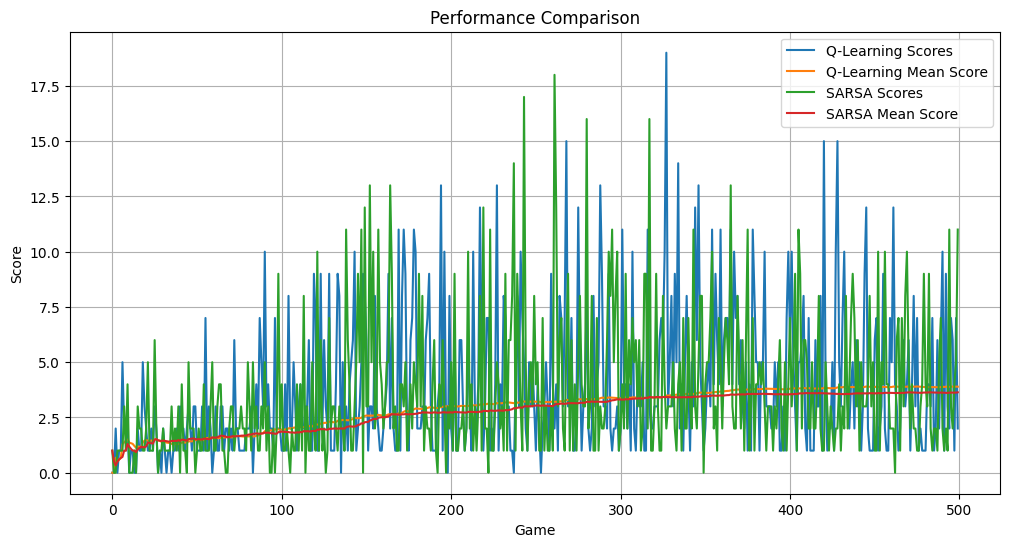


 Summary:
Q-Learning -> Best Score: 19, Avg Score: 3.89, Time: 40.72s
SARSA      -> Best Score: 18, Avg Score: 3.64, Time: 43.97s


In [ ]:
from IPython.display import HTML
from base64 import b64encode

def show_video_in_colab(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML(f"""
    <video width="640" height="480" controls>
        <source src="{data_url}" type="video/mp4">
    </video>
    """)

video_path = train_and_record()
show_video_in_colab(video_path)
